# LDA Topic Model 

This code is pulled from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. 

We apply an LDA Topic Model to reviews of companies on Glassdoor to understand what topics/categories people talk about when describing their work place / work experience.  

## Import Libraries

In [1]:
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorgilmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/connorgilmore/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
extended_stop_words = ['guys', 'syndicated', 'mentoring', 'syndicate', 'club', 'mentor', 'thing', 'people', 'really']
stop_words.extend(extended_stop_words)

## Import Data

In [5]:
transcripts_df = pd.read_csv('transcripts_df.csv')

In [6]:
transcripts_df.head()

,Unnamed: 0,file_name,contents
0,0,[UPDATED] PC - February 2021 - Mastermind with...,"other hand if he says, You give me 5% of every..."
1,1,"April 8, 2021 - Ask the Mentors Q_A Call on De...","JO\n\noften, it's 100%, smokescreen, nobody li..."
2,2,"April 14, 2021 - Ask the Mentors Q_A Call on C...","JO\n\nJO\n\nbelieve in that, and then develop ..."
3,3,April 2021 - Ask the Mentors Q_A Call on Busin...,JO\n\nyour investor questionnaire. So you can ...
4,4,April 2021 - Ask the Mentors Q_A Call on Sales...,©) Craig Kamman_ 30:35\n\nJO\n\nyes. Okay. So ...


## Data Prep

In [7]:
data = transcripts_df['contents']
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def remove_stopwords(texts):
    stop_words2 = stop_words + extended_stop_words
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words2] for doc in texts]

def remove_extra_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in extended_stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

data_words_nostops = remove_extra_stopwords(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

## LDA

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=10, step=1)

## Visualize Performance Metrics

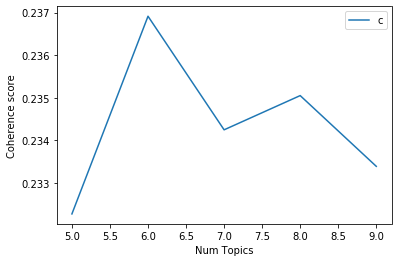

In [14]:
limit=10; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2323
Num Topics = 6  has Coherence Value of 0.2369
Num Topics = 7  has Coherence Value of 0.2342
Num Topics = 8  has Coherence Value of 0.2351
Num Topics = 9  has Coherence Value of 0.2334


Optimal Model

In [18]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.016*"question" + 0.015*"time" + 0.012*"lot" + 0.012*"money" + '
  '0.011*"deal" + 0.010*"property" + 0.009*"investor" + 0.009*"work" + '
  '0.009*"way" + 0.009*"thing" + 0.009*"point" + 0.008*"year" + '
  '0.007*"business" + 0.007*"syndication" + 0.007*"problem" + 0.006*"market" + '
  '0.006*"part" + 0.005*"person" + 0.005*"kind" + 0.005*"number" + '
  '0.005*"contract" + 0.005*"tax" + 0.004*"want" + 0.004*"call" + 0.004*"loan" '
  '+ 0.004*"project" + 0.004*"day" + 0.004*"building" + 0.004*"sale" + '
  '0.004*"stuff"'),
 (1,
  '0.018*"question" + 0.017*"deal" + 0.015*"time" + 0.014*"money" + '
  '0.014*"business" + 0.013*"way" + 0.012*"thing" + 0.011*"investor" + '
  '0.010*"property" + 0.009*"work" + 0.008*"point" + 0.008*"year" + '
  '0.007*"problem" + 0.007*"lot" + 0.006*"know" + 0.006*"part" + '
  '0.006*"market" + 0.006*"want" + 0.006*"syndication" + 0.005*"person" + '
  '0.005*"team" + 0.005*"tax" + 0.005*"value" + 0.005*"company" + 0.005*"talk" '
  '+ 0.005*"kind" + 0

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10)
model_topics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics(num_words=30))

[(0,
  '0.024*"deal" + 0.020*"time" + 0.014*"question" + 0.013*"way" + '
  '0.012*"money" + 0.011*"lot" + 0.010*"business" + 0.009*"thing" + '
  '0.009*"property" + 0.009*"investor" + 0.009*"year" + 0.008*"work" + '
  '0.007*"market" + 0.007*"part" + 0.006*"point" + 0.006*"problem" + '
  '0.006*"want" + 0.006*"person" + 0.006*"idea" + 0.005*"company" + '
  '0.005*"number" + 0.005*"value" + 0.005*"price" + 0.005*"team" + '
  '0.005*"know" + 0.005*"contract" + 0.004*"syndication" + 0.004*"call" + '
  '0.004*"kind" + 0.004*"little_bit"'),
 (1,
  '0.015*"deal" + 0.015*"lot" + 0.015*"money" + 0.015*"question" + '
  '0.014*"time" + 0.013*"way" + 0.011*"year" + 0.011*"business" + '
  '0.011*"investor" + 0.010*"point" + 0.010*"market" + 0.010*"property" + '
  '0.009*"thing" + 0.008*"problem" + 0.007*"part" + 0.007*"tax" + '
  '0.006*"syndication" + 0.006*"loan" + 0.006*"project" + 0.006*"company" + '
  '0.005*"person" + 0.005*"value" + 0.005*"work" + 0.005*"call" + 0.004*"want" '
  '+ 0.004*"b

## Visualize Topics

## Get Topic Distribution

In [ ]:
ldaModel.get_document_topics(bagOfWordOfADocument, minimum_probability=0.0)